In [18]:
#Importar librerías.

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
plt.style.use('fivethirtyeight')
from bs4 import BeautifulSoup
import requests
import datetime
import pyarrow
import openmeteo_requests

import requests_cache

from retry_requests import retry
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Configurar acceso Open-Meteo API client 
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Ingreso de las variables necesarias
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 40.7143,
	"longitude": -74.006,
	"start_date": "2023-12-01",
	"end_date": "2024-02-29",
	"hourly": ["temperature_2m", "rain", "snowfall", "snow_depth", "wind_speed_100m"],
	"daily": ["temperature_2m_max", "temperature_2m_min", "rain_sum", "snowfall_sum"],
	"timezone": "America/New_York"
}
responses = openmeteo.weather_api(url, params=params)


response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Procesando los datos por hora. El orden de las variables debe ser respetado
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_rain = hourly.Variables(1).ValuesAsNumpy()
hourly_snowfall = hourly.Variables(2).ValuesAsNumpy()
hourly_snow_depth = hourly.Variables(3).ValuesAsNumpy()
hourly_wind_speed_100m = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["rain"] = hourly_rain
hourly_data["snowfall"] = hourly_snowfall
hourly_data["snow_depth"] = hourly_snow_depth
hourly_data["wind_speed_100m"] = hourly_wind_speed_100m

hourly_dataframe = pd.DataFrame(data = hourly_data)


# Procesando los datos por día. El orden de las variables debe ser respetado
daily = response.Daily()
daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
daily_snowfall_sum = daily.Variables(3).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily_temperature_2m_max
daily_data["temperature_2m_min"] = daily_temperature_2m_min
daily_data["rain_sum"] = daily_rain_sum
daily_data["snowfall_sum"] = daily_snowfall_sum

daily_dataframe = pd.DataFrame(data = daily_data)



Coordinates 40.738136291503906°N -74.04254150390625°E
Elevation 51.0 m asl
Timezone b'America/New_York' b'EDT'
Timezone difference to GMT+0 -14400 s


In [20]:
daily_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date                91 non-null     datetime64[ns, UTC]
 1   temperature_2m_max  91 non-null     float32            
 2   temperature_2m_min  91 non-null     float32            
 3   rain_sum            91 non-null     float32            
 4   snowfall_sum        91 non-null     float32            
dtypes: datetime64[ns, UTC](1), float32(4)
memory usage: 2.3 KB


In [27]:
hourly_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2184 entries, 0 to 2183
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   date             2184 non-null   datetime64[ns, UTC]
 1   temperature_2m   2184 non-null   float32            
 2   rain             2184 non-null   float32            
 3   snowfall         2184 non-null   float32            
 4   snow_depth       2184 non-null   float32            
 5   wind_speed_100m  2184 non-null   float32            
dtypes: datetime64[ns, UTC](1), float32(5)
memory usage: 59.8 KB


In [28]:
hourly_dataframe.head()

,date,temperature_2m,rain,snowfall,snow_depth,wind_speed_100m
0,2023-12-01 04:00:00+00:00,4.5225,0.0,0.0,0.0,31.060303
1,2023-12-01 05:00:00+00:00,4.2225,0.0,0.0,0.0,30.037897
2,2023-12-01 06:00:00+00:00,3.0225,0.0,0.0,0.0,24.951921
3,2023-12-01 07:00:00+00:00,2.4225,0.0,0.0,0.0,25.071098
4,2023-12-01 08:00:00+00:00,1.6225,0.0,0.0,0.0,24.203140


In [21]:
daily_dataframe.head()

,date,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum
0,2023-12-01 04:00:00+00:00,7.622500,-0.4275,5.300000,0.0
1,2023-12-02 04:00:00+00:00,15.972501,4.1725,0.100000,0.0
2,2023-12-03 04:00:00+00:00,9.922500,5.5225,16.200003,0.0
3,2023-12-04 04:00:00+00:00,10.672500,4.5725,0.000000,0.0
4,2023-12-05 04:00:00+00:00,6.422500,1.3225,0.000000,0.0


In [22]:
daily_dataframe.describe()

,temperature_2m_max,temperature_2m_min,rain_sum,snowfall_sum
count,91.000000,91.000000,91.000000,91.000000
mean,6.948324,-1.386841,4.220880,0.417692
std,4.529627,4.053907,11.320095,2.149188
min,-4.377500,-9.177500,0.000000,0.000000
25%,4.197500,-4.227500,0.000000,0.000000
50%,6.572500,-2.227500,0.000000,0.000000
75%,9.347500,1.222500,1.250000,0.000000
max,16.922499,9.872500,78.900002,19.110001


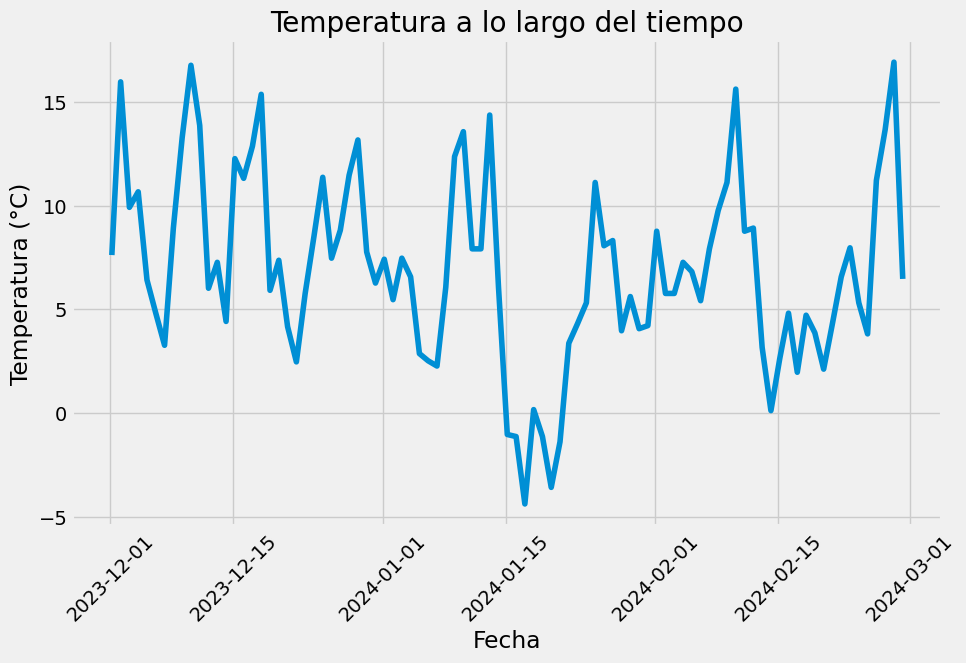

In [23]:
# Graficar la temperatura a lo largo del tiempo
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='temperature_2m_max', data=daily_dataframe)
plt.title('Temperaturas maximas a lo largo del tiempo')
plt.xlabel('Fecha')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


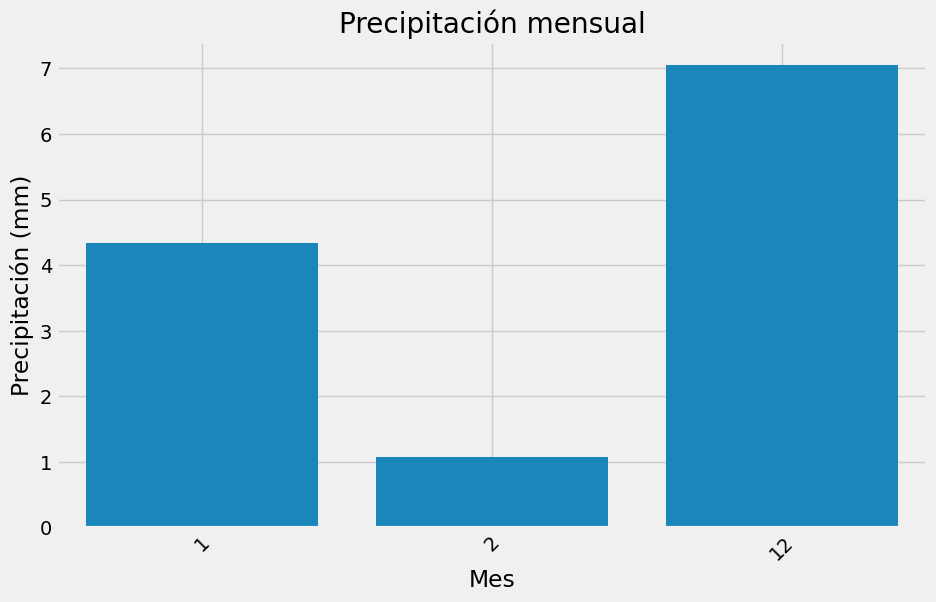

In [24]:
# Graficar la precipitación mensual

daily_dataframe['mes'] = daily_dataframe['date'].dt.month

plt.figure(figsize=(10, 6))
sns.barplot(x='mes', y='rain_sum', data=daily_dataframe, ci=None)
plt.title('Precipitación mensual')
plt.xlabel('Mes')
plt.ylabel('Precipitación (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

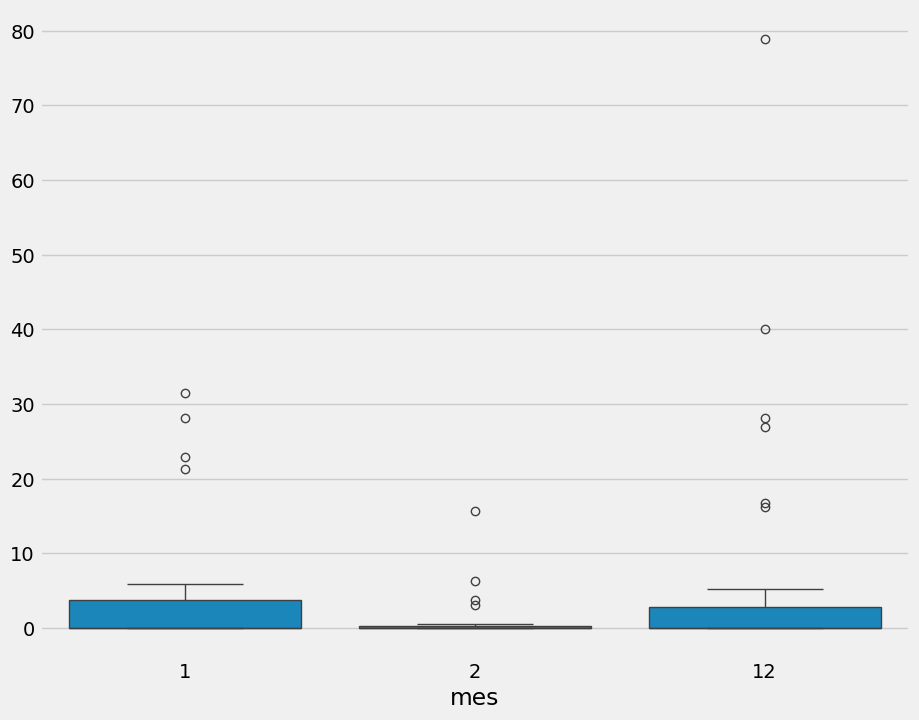

In [25]:
# Precipitacion mensual
plt.subplots(figsize=(10,8))
sns.boxplot(x='mes',y='rain_sum',data=daily_dataframe)
plt.ylabel('')
plt.show()

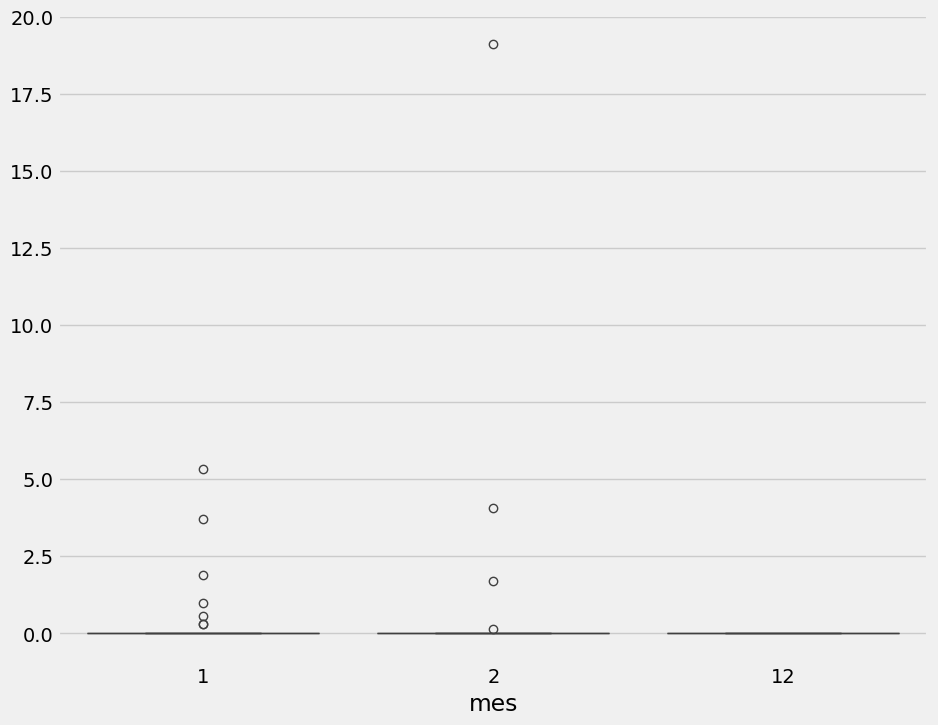

In [26]:
daily_dataframe['snowfall_sum'].sum()

# Precipitacion Nieve
plt.subplots(figsize=(10,8))
sns.boxplot(x='mes',y='snowfall_sum',data=daily_dataframe)
plt.ylabel('')
plt.show()

In [29]:
hourly_dataframe.head(2)


,date,temperature_2m,rain,snowfall,snow_depth,wind_speed_100m
0,2023-12-01 04:00:00+00:00,4.5225,0.0,0.0,0.0,31.060303
1,2023-12-01 05:00:00+00:00,4.2225,0.0,0.0,0.0,30.037897


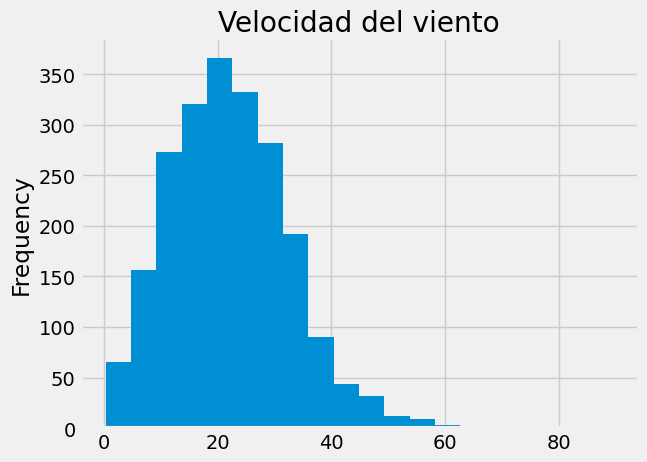

In [30]:
hourly_dataframe['wind_speed_100m'].plot(kind='hist', bins=20, title='Velocidad del viento')
plt.gca().spines[['top', 'right',]].set_visible(False)